# Q1: Player Consistency in Scoring, Rebounding, and Assists

The goal of this notebook is to identify the most consistent players across key performance metrics.


We define consistency as low game-to-game variability:
- We compute the mean and standard deviation of PTS, TRB, and AST across all their games.
- Players with the lower standard deviation, given a reasonable number of games, are considered more consistent. 

I plan to: 
1. Load the game-level data
2. Filter by players with a minimum number of games played
3. Computer per-player mean and std of PTS, TRB, and AST
4. Rank players by consistency
5. Visualize the most consistent players using boxplots and scatterplots

Imports for future plotting and data manipulation.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import add_gamekey_and_win, add_per_minute_stats


df = pd.read_csv("data/player_game_stats_clean.csv")

Filter the dataset to only include players with enough games. I chose 30 games because it seems like a reasonable amount of games to get a good variability of statistics from. We don't want players that have played only 1 game and never varied. I set a variable for min_games so we can easily adjust it as well.

In [3]:
min_games = 30

games_per_player = df.groupby("Player")["PTS"].count().rename("GamesPlayed")
games_per_player.head()

# Merge games played into the main df
df = df.merge(games_per_player, on="Player")

# Filter
df_filtered = df[df["GamesPlayed"] >= min_games].copy()
print("Original players:", games_per_player.shape[0])
print("Players with at least", min_games, "games:", df_filtered["Player"].nunique())


Original players: 562
Players with at least 30 games: 305


Now I compute the consistency metrics per player by grouping by player and team to get their PTS, TRB, and AST mean and standard deviation. 

In [13]:
player_consistency = (
    df_filtered
    .groupby(["Player", "Tm"])
    .agg(
        GamesPlayed=("PTS", "count"),
        PTS_mean=("PTS", "mean"),
        PTS_std=("PTS", "std"),
        TRB_mean=("TRB", "mean"),
        TRB_std=("TRB", "std"),
        AST_mean=("AST", "mean"),
        AST_std=("AST", "std")
    )
    .reset_index()
)

player_consistency["PTS_cv"] = player_consistency["PTS_std"] / player_consistency["PTS_mean"].replace(0, np.nan)
player_consistency["TRB_cv"] = player_consistency["TRB_std"] / player_consistency["TRB_mean"].replace(0, np.nan)
player_consistency["AST_cv"] = player_consistency["AST_std"] / player_consistency["AST_mean"].replace(0, np.nan)

player_consistency.head()

,Player,Tm,GamesPlayed,PTS_mean,PTS_std,TRB_mean,TRB_std,AST_mean,AST_std,PTS_cv,TRB_cv,AST_cv
0,A.J. Green,MIL,44,7.659091,5.382760,2.250000,1.780057,1.272727,1.318273,0.702794,0.791137,1.035786
1,Aaron Gordon,DEN,30,12.333333,6.608946,4.733333,2.981938,3.066667,2.531639,0.535860,0.629987,0.825534
2,Aaron Holiday,HOU,36,4.222222,3.742506,0.944444,1.067559,1.194444,1.214659,0.886383,1.130357,1.016924
3,Aaron Wiggins,OKC,51,10.137255,6.720177,3.568627,2.492027,1.568627,1.374844,0.662919,0.698315,0.876463
4,Adem Bona,PHI,36,3.000000,3.144156,2.833333,2.489980,0.305556,0.524783,1.048052,0.878816,1.717470


Now I rank players by their consistency, which I define as the smallest standard deviation in each statistic. I .head(10) to limit the top 10 most consistent scorers from PTS, rebounders from TRB, and playmakers from AST

In [18]:
min_games = 30

player_consistency_filtered = player_consistency[
    player_consistency["GamesPlayed"] >= min_games].copy()

# Top 10 most consistent scorers
top_consistent_pts = (
    player_consistency_filtered
    .sort_values(["PTS_std", "PTS_mean"], ascending=[True, False])
    .head(10))

# Top 10 most consistent rebounders
top_consistent_trb = (
    player_consistency_filtered
    .sort_values(["TRB_std", "TRB_mean"], ascending=[True, False])
    .head(10))

# Top 10 most consistent playmakers/assists
min_ast_mean = 2.0 

pc = player_consistency[player_consistency["GamesPlayed"] >= min_games].copy()
ast_cutoff = pc["AST_mean"].quantile(0.75)
playmakers = pc[pc["AST_mean"] >= ast_cutoff].copy()


top_consistent_ast = (
    playmakers
    .sort_values(["AST_std", "AST_mean"], ascending=[True, False])
    .head(10)
)

top_consistent_ast[["Player","Tm","GamesPlayed","AST_mean","AST_std"]]

,Player,Tm,GamesPlayed,AST_mean,AST_std
116,Isaiah Hartenstein,OKC,31,4.129032,1.802627
148,Jaylen Brown,BOS,45,4.777778,1.832644
37,CJ McCollum,NOP,38,3.815789,1.872349
45,Caris LeVert,CLE,38,3.684211,1.918689
99,Dyson Daniels,ATL,47,3.957447,1.921927
89,Donovan Mitchell,CLE,49,4.734694,1.955500
135,Jalen Suggs,ORL,35,3.685714,2.011313
136,Jalen Williams,OKC,48,5.083333,2.019409
201,Kyrie Irving,DAL,41,4.804878,2.039847
287,T.J. McConnell,IND,49,4.510204,2.072865


Using seaborn to visualize game-by-game distributions for the top 10 most consistent scorers. 

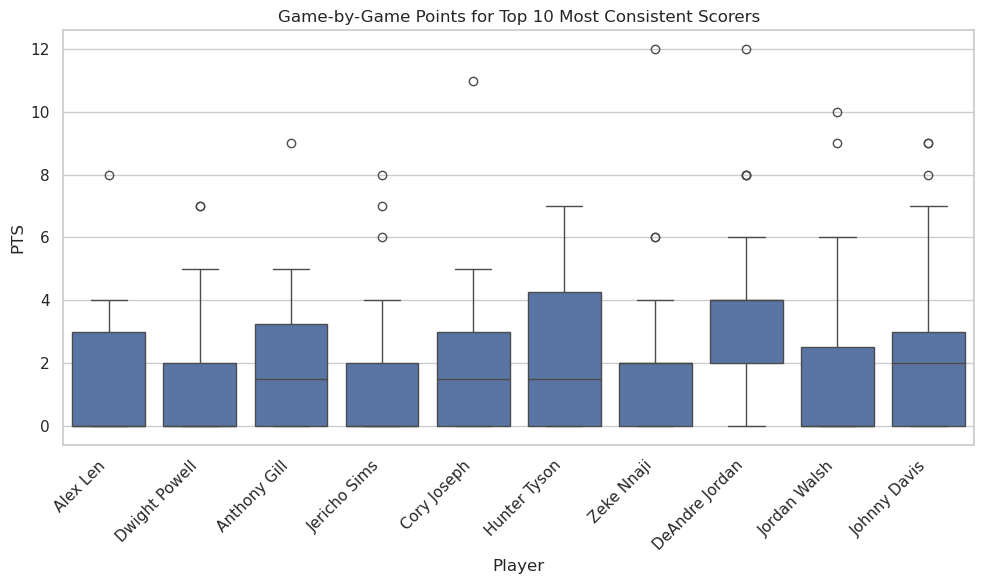

In [36]:
# Get the names of the top 10 consistent scorers
top_pts_players = top_consistent_pts["Player"].tolist()

df_top_pts = df_filtered[df_filtered["Player"].isin(top_pts_players)].copy()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top_pts,
    x="Player",
    y="PTS",
    order=top_pts_players)

plt.xticks(rotation=45, ha="right")
plt.title("Game-by-Game Points for Top 10 Most Consistent Scorers")
plt.ylabel("PTS")
plt.xlabel("Player")
plt.tight_layout()
plt.show()

# 

Using seaborn to visualize game-by-game distributions for the top 10 most consistent rebounders and playmakers, similar to the plot above. 

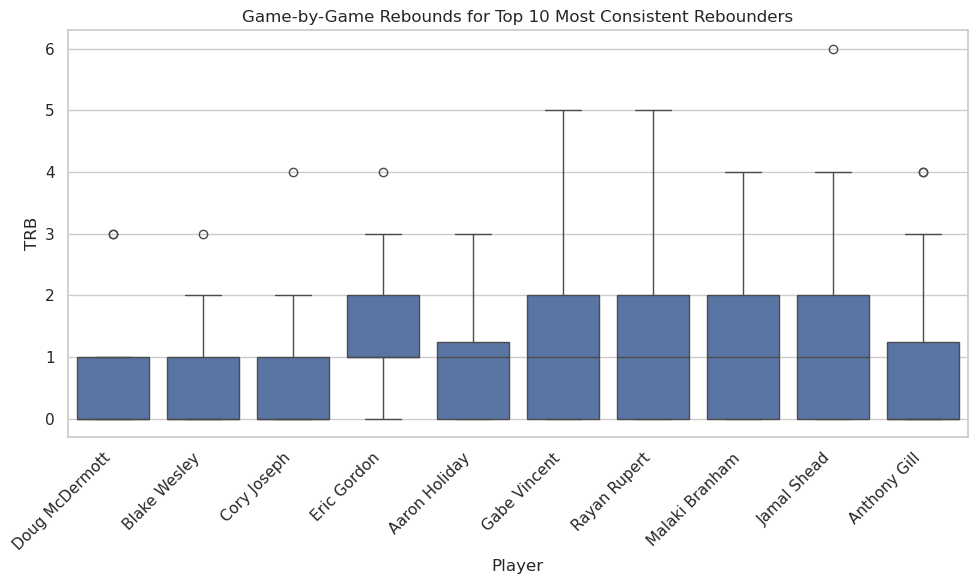

In [34]:
# Top 10 rebounders by consistency
top_trb_players = top_consistent_trb["Player"].tolist()
df_top_trb = df_filtered[df_filtered["Player"].isin(top_trb_players)].copy()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top_trb,
    x="Player",
    y="TRB",
    order=top_trb_players)

plt.xticks(rotation=45, ha="right")
plt.title("Game-by-Game Rebounds for Top 10 Most Consistent Rebounders")
plt.ylabel("TRB")
plt.xlabel("Player")
plt.tight_layout()
plt.show()

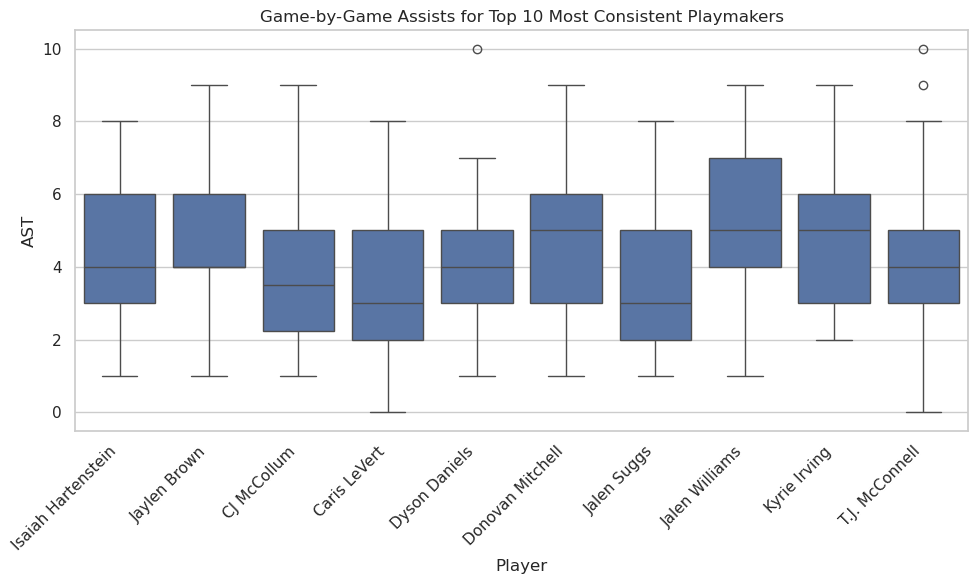

In [31]:
top_ast_players = top_consistent_ast["Player"].tolist()

df_top_ast = df_filtered[df_filtered["Player"].isin(top_ast_players)].copy()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_top_ast, x="Player", y="AST", order=top_ast_players)
plt.xticks(rotation=45, ha="right")
plt.title("Game-by-Game Assists for Top 10 Most Consistent Playmakers")
plt.tight_layout()
plt.show()

Mean versus Variability scatterplots to visualize the tradeoff between volume and consistency for points, rebounds, and assists.

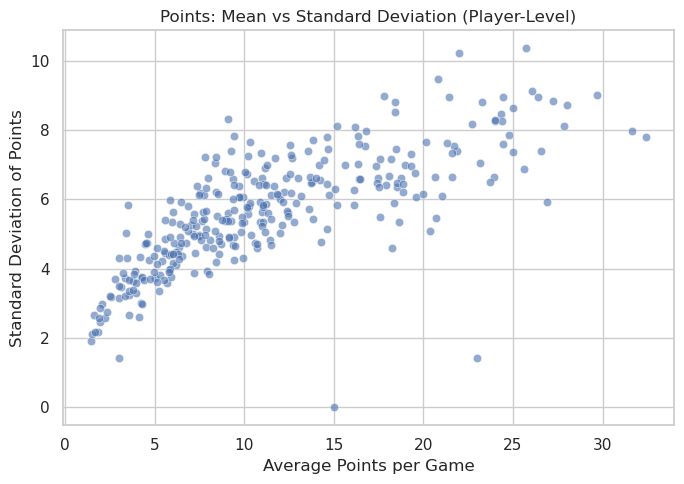

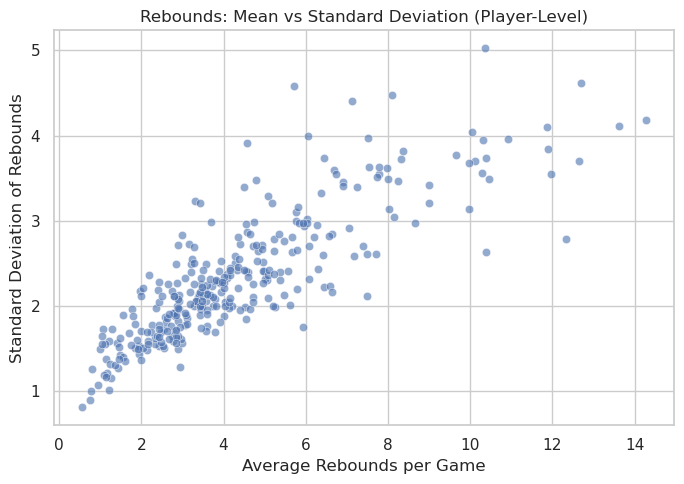

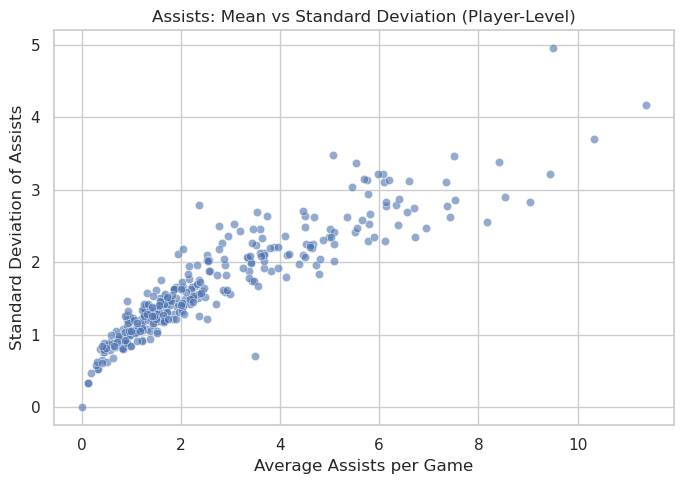

In [32]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=player_consistency,
    x="PTS_mean",
    y="PTS_std",
    alpha=0.6
)
plt.title("Points: Mean vs Standard Deviation (Player-Level)")
plt.xlabel("Average Points per Game")
plt.ylabel("Standard Deviation of Points")
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=player_consistency,
    x="TRB_mean",
    y="TRB_std",
    alpha=0.6
)
plt.title("Rebounds: Mean vs Standard Deviation (Player-Level)")
plt.xlabel("Average Rebounds per Game")
plt.ylabel("Standard Deviation of Rebounds")
plt.tight_layout()
plt.show()



plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=player_consistency,
    x="AST_mean",
    y="AST_std",
    alpha=0.6
)
plt.title("Assists: Mean vs Standard Deviation (Player-Level)")
plt.xlabel("Average Assists per Game")
plt.ylabel("Standard Deviation of Assists")
plt.tight_layout()
plt.show()